In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import packages and formatting statements

import numpy as np
import math
from matplotlib import pyplot as plt
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os
from astropy.coordinates import SkyCoord, Angle
from astropy.nddata import Cutout2D
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle
from matplotlib.patches import Circle

plt.rc('text',usetex=False)
fontsize=10
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

In [3]:
# Compile galaxy and OSC objects
# full catalog header: Name,Type,Host,RA hms,Dec dms,RA dds,Dec dds,DiscDate

DataFile = '../Data/2.MUSESampleCat.csv'
Data = Table.read(DataFile, format='csv') 
MUSEres, MUSENatMaps, MUSEHII = Data["MUSERes"], Data["MUSENatMap"], Data["MUSEHII"]

Data

Galaxy,Distance,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSEHII,InSample
str7,float64,str11,str12,float64,float64,float64,str71,str70,str50,str4
NGC1087,15.9,SN1995V,II,41.61152777777777,-0.4987861111111111,0.92,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1087-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,True
NGC1300,19.0,SN2022acko,II,49.91245833333333,-19.39518888888889,0.89,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1300-0.89asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1300-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1300_nebulae_mask_V2.fits,True
NGC1365,19.6,SN1957C,Unclassified,53.38349999999999,-36.11770833333333,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,True
NGC1365,19.6,SN1983V,Ic,53.381876388888884,-36.14859166666667,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,True
NGC1365,19.6,SN2001du,II,53.3713125,-36.142111111111106,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,True
NGC1365,19.6,SN2012fr,Ia,53.40057916666666,-36.12676944444445,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,True
NGC1433,18.6,SN1985P,II,55.52640625,-47.209987222222225,0.91,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1433-0.91asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1433-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1433_nebulae_mask_V2.fits,True
...,...,...,...,...,...,...,...,...,...,...
NGC4303,17.0,SN2014dt,Ia Pec,185.48991666666666,4.471777777777778,0.78,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC4303-0.78asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC4303-150pc_MAPS.fits,../Data/HII_reg_masks/NGC4303_nebulae_mask_V2.fits,True


In [4]:
#group sample by galaxy
gal_groups = Data.group_by('Galaxy')
galaxies = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()
indices.append(0)

imgs, HIIimgs, names, types, ras, decs, dists, res = [],[],[],[],[],[],[],[]

for i in range(len(indices)-2):
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]

    imgs.append(gal_groups["MUSENatMap"][indices[i]])
    HIIimgs.append(gal_groups["MUSEHII"][indices[i]])
    dists.append(gal_groups["Distance"][indices[i]])
    res.append(gal_groups["MUSERes"][indices[i]])
    
    #if gal_groups["SN_name"][indices[i]] != "SN1989B" and gal_groups["SN_name"][indices[i]] != "SN1973R":
    # Attach first SN per galaxy to a list
    SNnames.append(gal_groups["Supernova"][indices[i]])
    SNtypes.append(gal_groups["Type"][indices[i]])
    SNras.append(gal_groups["Ra"][indices[i]])
    SNdecs.append(gal_groups["Dec"][indices[i]])
    j = 1
    # attach additional  SN to list when galaxy has more than one
    while(indices[i] + j < indices[i+1]):    
        #if gal_groups["SN_name"][indices[i]+j] != "SN1989B" and gal_groups["SN_name"][indices[i]+j] != "SN1973R":
        SNnames.append(gal_groups["Supernova"][indices[i]+j])
        SNtypes.append(gal_groups["Type"][indices[i]+j])
        SNras.append(gal_groups["Ra"][indices[i]+j])
        SNdecs.append(gal_groups["Dec"][indices[i]+j])
        j += 1
    names.append(SNnames)
    types.append(SNtypes)
    ras.append(SNras)
    decs.append(SNdecs)

print(names)
print(dists)

[['SN1995V'], ['SN2022acko'], ['SN1957C', 'SN1983V', 'SN2001du', 'SN2012fr'], ['SN1985P'], ['ASASSN-14ha', 'SN2010el', 'SN2021aefx'], ['SN2017gax', 'SN2022aau'], ['SN1973R', 'SN1989B', 'SN1997bs', 'SN2009hd', 'SN2016cok'], ['SN1967H', 'SN1972Q', 'SN1986I', 'SN2014L'], ['SN1926A', 'SN1961I', 'SN1964F', 'SN1999gn', 'SN2006ov', 'SN2014dt', 'SN2020jfo'], ['SN1901B', 'SN1959E', 'SN2006X', 'SN2019ehk', 'SN2020oi']]
[15.9, 19.0, 19.6, 18.6, 17.7, 19.4, 11.3, 13.1, 17.0, 15.2]


In [5]:
def getPlotStuff(gal, img, res, HIIimg, names, types, ras, decs, dist):
    plots, wcss, HIImaps, hdus, SNnames, SNtypes, SNras, SNdecs, SNgals, dists, resolution, inHII = [],[],[],[],[],[],[],[],[],[],[],[]

    for i in range(len(gal)):
        for j in range(len(names[i])):
            
            if os.path.isfile(img[i]) and os.path.isfile(HIIimg[i]):

                #get hdu & wcs for MUSE map
                ha_hdu = pyfits.open(img[i])
                hdus.append(ha_hdu)
                ha_map = ha_hdu["HA6562_FLUX"].data
                w = WCS(ha_hdu["HA6562_FLUX"].header, naxis=2)
                wcss.append(w)                
                plots.append(ha_map)
                resolution.append(res[i])
                
                #get XXX for HII map
                hii_hdu = pyfits.open(HIIimg[i])
                hii_map = hii_hdu[0].data
                HIImaps.append(hii_map)

                SNnames.append(names[i][j])
                SNtypes.append(types[i][j])
                SNras.append(ras[i][j]) 
                SNdecs.append(decs[i][j])
                SNgals.append(gal[i])
                dists.append(dist[i])
                
                #Check if SN is in HII region
                xval, yval = w.wcs_world2pix(ras[i][j],decs[i][j], 0)
                xVal = int(xval)
                yVal = int(yval)
                HIIval = hii_map[yVal, xVal]

                if HIIval == -1:
                    inHII.append("No ")
                else:
                    inHII.append("Yes ")

            else:
                #print("no file for ")
                pass

    return(plots, wcss, HIImaps, hdus, SNnames, SNtypes, SNras, SNdecs, SNgals, dists, resolution, inHII)


In [6]:
# set up plots, wcs information, and HII maps for contours.

plots, wcss, HIImaps, hdus, SNnames, SNtypes, SNras, SNdecs, SNgals, dists, resolution, inHII = getPlotStuff(galaxies, imgs, res, HIIimgs, names, types, ras, decs, dists)

# print(SNnames)
print(len(SNnames))
print(len(inHII))

33
33


In [7]:
#set up labels for legends
legendLabels = []

for i in range(len(SNnames)):
    legendlabel = []
    if SNtypes[i][0] == 'unclassified':
        legendlabel.append(SNnames[i] + ' '  + SNtypes[i]) 
    else:        
        legendlabel.append(SNnames[i] + ' Type '  + SNtypes[i])
    legendLabels.append(legendlabel)

# print(legendLabels)


In [8]:
print(str(SNgals[10]))


 Galaxy
-------
NGC1672


In [9]:
# set size of boxes

# Next draw out the spheres of influence
def findAngSize(sphere, dist):
    """ Finds the angular size in decimal degrees when given the 
        size of the sphere in pc and the
        distance to the galaxy in Mpc
    """
    
    angSizeRad = np.arctan(sphere/(dist*10**6))
    angSize = angSizeRad * (180/np.pi)
        
    return(angSize)

sphereSizes = [10,50,200,500]
angSizes = []

for i in range(len(dists)):
    
    ang10 = findAngSize(sphereSizes[0], dists[i])
    ang50 = findAngSize(sphereSizes[1], dists[i])
    ang200 = findAngSize(sphereSizes[2], dists[i])
    ang500 = findAngSize(sphereSizes[3], dists[i])
    
    angSizes.append([ang10, ang50, ang200, ang500])
    

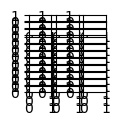

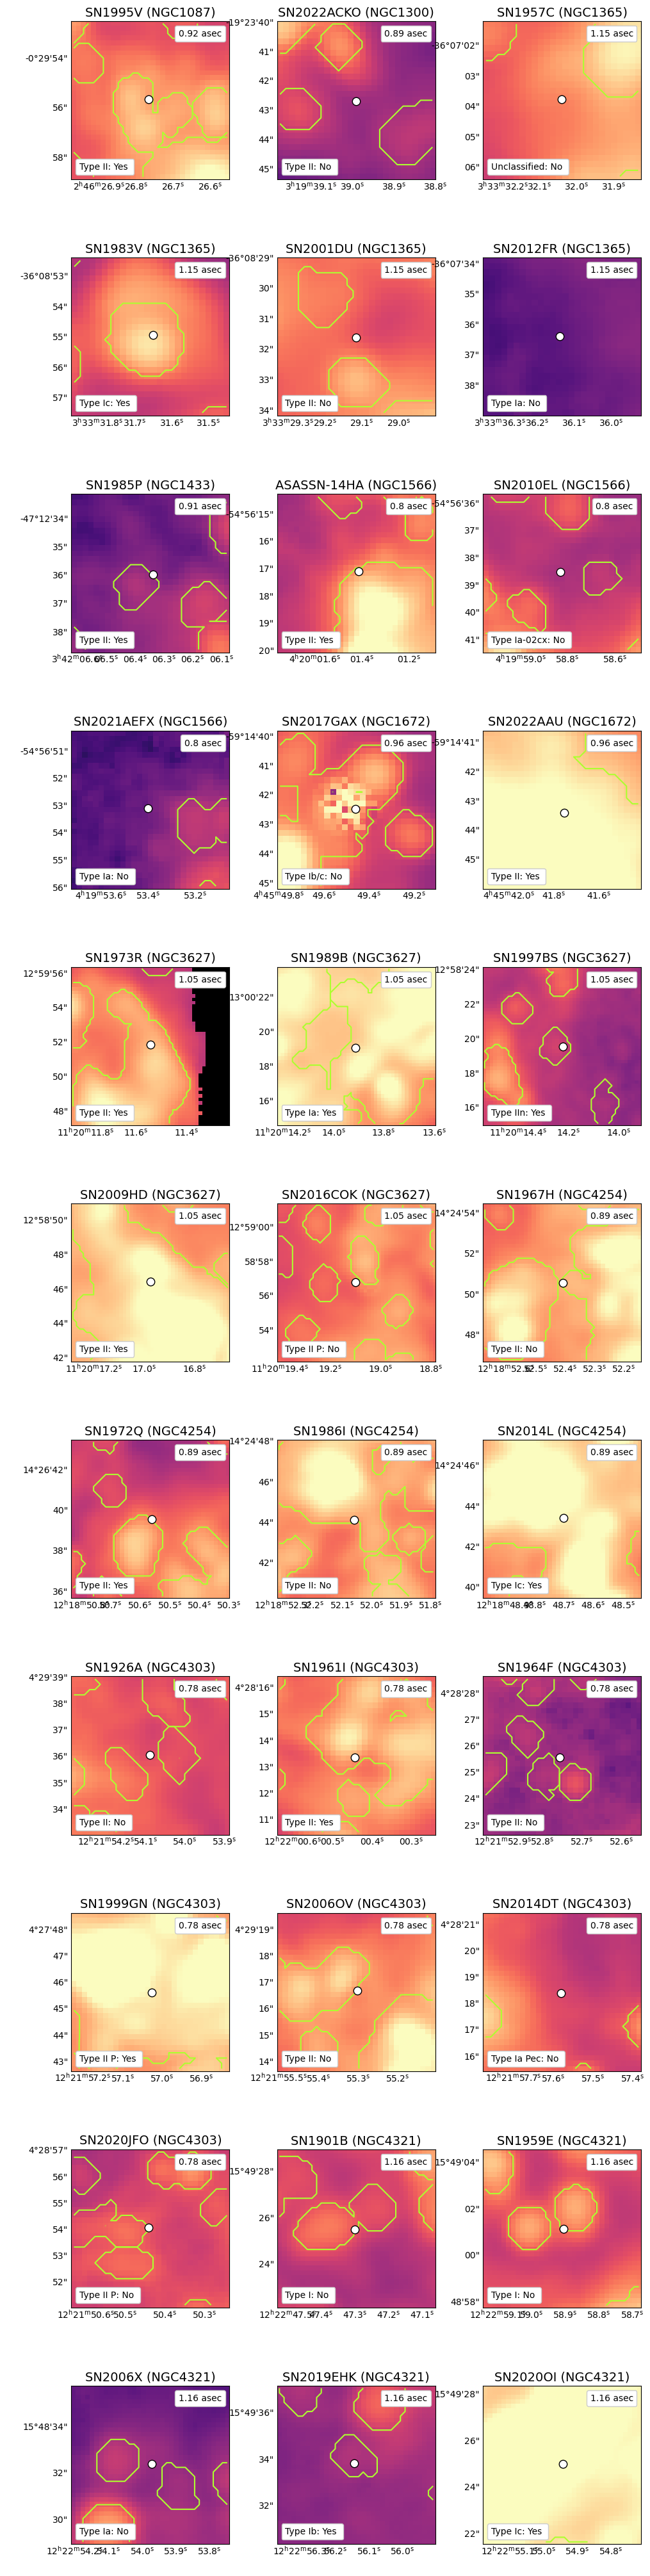

In [10]:
current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

NUM_SNE= 33
# halfBox = 0.00416667 # 15'' in degrees

m,n,p =0,0,0 # plot counters for total number, rows, columns
PLOTS_PER_ROW = 3

fig2, axs = plt.subplots(math.ceil(NUM_SNE/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(1, 1))
fig = plt.figure(figsize = (10,50))

for j in range(len(SNgals)): # counter to count galaxy maps
    
    #set up legend label with type classification
    if SNtypes[j] != "Unclassified":
        leglab = "Type " + SNtypes[j] + ": " + inHII[j]
    else:
        leglab= SNtypes[j] + ": " + inHII[j]
    legStr = str(resolution[j]) + " asec"
    
    #set up data to use astropy's cutout2D to plot subsections of galaxy map
    data = plots[j]
    logData = np.log10(data)    
    HIIData = HIImaps[j]
    wcs=wcss[j]

    halfBox = angSizes[j][3]/2. # 500 pc in decimal degrees/2?
    #cutout2D needs skycoord position to carry units
    ra, dec = Angle(SNras[j] * u.degree), Angle(SNdecs[j] * u.degree)
    raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
    position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
    #size = u.Quantity((20,20), u.arcsec) #size is size of box in arcsec 
    size = u.Quantity((angSizes[j][3],angSizes[j][3]), u.degree) #size is size of box in arcsec 
    # make 2D cutout, will assign a new wcs to cutout to keep track of coords
    cutout = Cutout2D(logData, position, size, wcs) 
    # use this new wcs when converting to pixels to add additional details to plot
    xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
    # get HII data for contours
    HIICutout = Cutout2D(HIIData, position, size, wcs)

    titleStr = SNnames[j].upper() + " (" + SNgals[j][0].upper() + ")"
    # make plot
    axs[m][n] = fig.add_subplot(11,3,p+1,projection = cutout.wcs)
    axs[m][n].set_title(titleStr, fontsize=14)            
    axs[m][n].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=1, vmax=4,interpolation = "nearest", zorder = 0)
    axs[m][n].scatter(xval, yval, color = "black", marker ="o", s = 60, zorder=2)
    axs[m][n].scatter(xval, yval, color = "white", marker = "o", s = 80, edgecolor="black",zorder = 2, label=leglab)
    axs[m][n].set_ylabel(" ")
    axs[m][n].set_xlabel(" ")
    axs[m][n].tick_params(axis = "both", direction = "in", length = 0)
    axs[m][n].contour(HIICutout.data, [3], colors = ["greenyellow"], linestyles = ("-"), zorder = 1)
   
    # add in second legend to say resolution
    resLeg = axs[m][n].legend([legStr],handlelength=0, handletextpad=0,loc="upper right", facecolor='white', framealpha=1.0)
    for item in resLeg.legendHandles:
        item.set_visible(False)
    axs[m][n].add_artist(resLeg)

    leg = axs[m][n].legend(handlelength=0, handletextpad=0, loc="lower left", facecolor='white', framealpha=1.0)
    for item in leg.legendHandles:
        item.set_visible(False)



    #get spheres of influence
#     spheres = angSizes[j][:-1]


#     #get Pixel distance for scalebar
#     pixDists=[]
#     for i in range(len(spheres)-1):
#         sphereEdgeRa, sphereEdgeDec = ra + Angle(spheres[i]*u.degree), dec + Angle(spheres[i]*u.degree)
#         sphereEdgex, sphereEdgey = cutout.wcs.wcs_world2pix(sphereEdgeRa, sphereEdgeDec, 0)
#         pixDistx, pixDisty = sphereEdgex-xval, sphereEdgey-yval
#         pixDists.append(np.sqrt((pixDistx**2 + pixDisty**2)/2))

#     lowerleftra  = ra.value + halfBox 
#     lowerleftdec = dec.value - halfBox + halfBox*0.1
#     val=spheres[1]

#     xArr, yArr = np.linspace(lowerleftra, lowerleftra-val, 100),np.linspace(lowerleftdec, lowerleftdec, 100)


    n+=1
    if n%PLOTS_PER_ROW==0:
        m+=1
        n=0
    p +=1

    plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.99, top = 0.9, wspace = 0.3, hspace = 0.2)
#plt.tight_layout(pad=0.5, w_pad=6.8, h_pad=1.0)
fig.savefig("../Figures/Zooms_500pc.pdf", dpi=300)
plt.show()


In [11]:
print(inHII, SNtypes)

['Yes ', 'No ', 'No ', 'Yes ', 'No ', 'No ', 'Yes ', 'Yes ', 'No ', 'No ', 'No ', 'Yes ', 'Yes ', 'Yes ', 'Yes ', 'Yes ', 'No ', 'No ', 'Yes ', 'No ', 'Yes ', 'No ', 'Yes ', 'No ', 'Yes ', 'No ', 'No ', 'No ', 'No ', 'No ', 'No ', 'Yes ', 'Yes '] ['II', 'II', 'Unclassified', 'Ic', 'II', 'Ia', 'II', 'II', 'Ia-02cx', 'Ia', 'Ib/c', 'II', 'II', 'Ia', 'IIn', 'II', 'II P', 'II', 'II', 'II', 'Ic', 'II', 'II', 'II', 'II P', 'II', 'Ia Pec', 'II P', 'I', 'I', 'Ia', 'Ib', 'Ic']


In [12]:
numInHII = sum('Yes' in s for s in inHII)


In [13]:
IIinHII, IainHII, IbcinHII, UncInHII = 0,0,0,0

for i in range(len(inHII)):
    if "Yes" in inHII[i] and "Ia" in SNtypes[i]:
        IainHII += 1
    elif "Yes" in inHII[i] and "II" in SNtypes[i]:
        IIinHII += 1
    elif "Yes" in inHII[i] and ("Ib" in SNtypes[i] or "Ic" in SNtypes[i]):
        IbcinHII += 1
    elif "Yes" in inHII[i]:
        UncInHII += 1
        
print(IIinHII, IainHII, IbcinHII, UncInHII)

10 1 4 0


In [14]:
print(len(SNtypes))

33


In [15]:
numII = sum('II' in s for s in SNtypes)
numIa = sum('Ia' in s for s in SNtypes)
numIb = sum('Ib' in s for s in SNtypes)
numIc = sum('Ic' in s for s in SNtypes)

In [16]:
print(numII, numIa, numIb, numIc)

19 6 2 3
